In [1]:
from madigan.environments import make_env
from madigan.utils.preprocessor import StackerDiscrete
from madigan.utils.config import make_config

import numpy as np
import matplotlib.pyplot as plt

In [62]:
config_sine = make_config("sineComp", assets=["sineC1"],
                          data_source_type="SineAdder",
                          data_source_config={
                            'freq':[2.2, .1, 4.7, 3.3],
                            'mu':[.6, 0.3, 2., 4.2],
                            'amp':[.5, 0.2, 0.4, 1.2],
                            'phase':[0., .5, .6, 0.2],
                            'dX':0.01,
                            "noise": 0.1},
                         )
env_sine = make_env(config_sine)


In [63]:
config_ou = make_config("OU", assets=["ou1"],
                        data_source_type="OU",
                        data_source_config=dict(
                            mean=[10., 5., 1.],
                            theta=[.15, .15, .15],
                            phi = [.04, .04, .04])
                        )
env_ou = make_env(config_ou)

In [64]:
config_trend = make_config("SimpleTrend", assets=["trend1"],
                        data_source_type="SimpleTrend",
                        data_source_config=dict(
                            trend_prob=[.01],
                            min_period=[100],
                            max_period=[500],
                            noise = [.01],
                            dYMin = [0.001],
                            dYMax = [0.005],
                            start = [5.0])
                        )
env_trend = make_env(config_trend)

In [65]:
config_trend_ou = make_config("TrendOU", assets=["trendOU1"],
                        data_source_type="TrendOU",
                        data_source_config=dict(
                            trend_prob=[.001],
                            noise_trend = [.001],
                            min_period=[100],
                            max_period=[500],
                            dYMin = [0.005],
                            dYMax = [0.01],
                            start = [5.0],
                            theta = [0.15],
                            phi = [0.04],
                            ema_alpha = [0.3])
                        )
env_trend_ou = make_env(config_trend_ou)

In [66]:
config_trendy_ou = make_config("TrendOU", assets=["trendOU1"],
                        data_source_type="TrendyOU",
                        data_source_config=dict(
                            trend_prob=[.01],
                            noise_trend = [.1],
                            min_period=[200],
                            max_period=[1000],
                            dYMin = [0.0001],
                            dYMax = [0.0005],
                            start = [5.0],
                            theta = [.15],
                            phi = [0.04],
                            ema_alpha = [0.99])
                        )
env_trendy_ou = make_env(config_trendy_ou)

In [67]:
env_sine.assets , env_trend.assets, env_ou.assets, env_trend_ou.assets, env_trendy_ou.assets

([multi_sine], [SimpleTrend_0], [OU_0, OU_1, OU_2], [TrendOU_0], [TrendyOU_0])

In [68]:
window_sine = StackerDiscrete(128, env_sine.nAssets)
window_ou = StackerDiscrete(128, norm=False, n_assets=env_ou.nAssets) 
window_trend = StackerDiscrete(1280, env_trend.nAssets)
window_trend_ou = StackerDiscrete(1280, env_trend_ou.nAssets)
window_trendy_ou = StackerDiscrete(1280, env_trendy_ou.nAssets, norm=False)


In [69]:
env_sine.reset()
env_ou.reset()
env_trend.reset()
env_trend_ou.reset()
env_trendy_ou.reset()

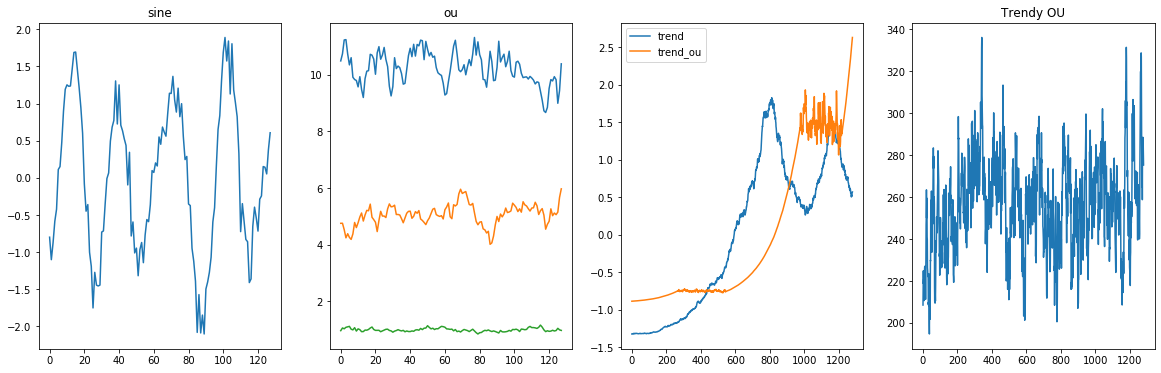

In [77]:
for i in range(12800):
    window_sine.stream(env_sine.step())
    window_ou.stream(env_ou.step())
    window_trend.stream(env_trend.step())
    window_trend_ou.stream(env_trend_ou.step())
    window_trendy_ou.stream(env_trendy_ou.step())

fig, ax = plt.subplots(1,4, figsize=(20, 6))
ax[0].plot(window_sine.current_data().price, label='sine')
ax[0].set_title('sine')
ax[1].plot(window_ou.current_data().price, label='ou')
ax[1].set_title('ou')
ax[2].plot(window_trend.current_data().price, label='trend')
ax[2].plot(window_trend_ou.current_data().price, label='trend_ou')
ax[3].plot(window_trendy_ou.current_data().price, label='trend_ou')
ax[3].set_title('Trendy OU')
ax[2].legend()

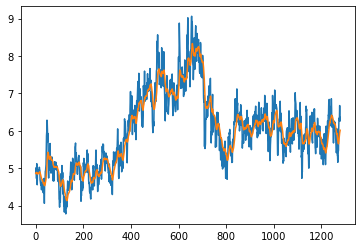

In [71]:
data = window_trendy_ou.current_data().price
def ewm(data, alpha=0.99):
    curr = data[0]
    out = [curr]
    for dat in data[1:]:
        curr = (1-alpha)*curr + alpha*dat
        out.append(curr)
    return np.array(out)
        
plt.plot(data)
plt.plot(ewm(data, alpha=.1))


In [72]:
window_trend_ou.current_data().price, env_trend_ou.currentPrices, window_trendy_ou.current_data().price

(array([[ 0.91732951],
        [ 1.09215686],
        [ 1.06207445],
        ...,
        [-1.17965633],
        [-1.18460632],
        [-1.17570465]]),
 array([0.3986268]),
 array([[4.86162236],
        [4.88210466],
        [5.01556384],
        ...,
        [6.67520598],
        [6.25716228],
        [6.35348028]]))

In [76]:
import numba

@numba.njit
def trend_ou():
    x = 0.
    y = 1
    ema = y
    dx = 0.01
    dy = 0.001
    theta = 1
    phi = .5
    noise_var = 0.01
    emaAlpha = 0.9
    
    trending = False
    directions = np.array((-1, 1))
    current_direction = directions[1]
    noise = 0.05
    trend_len=0
    prev_y = y
    ou_noise = 0.
    ou_process = 0.
    while True:
#         prev_y = y
#         ema = emaAlpha*y + (1-emaAlpha)*ema
        if trending:
            y += y*dy*current_direction +  y*np.random.normal(0, noise_var)
            y = max(0.01, y)
            trend_len -= 1
            if trend_len == 0:
                trending=False
                prev_y = y
            if y <= 0.01:
                current_direction = 1
            
        else:
            ou_noise = y*phi*np.random.normal(0, noise)
            ou_process = theta*(prev_y-y)
#             print(ou_noise, ou_process, ou_noise+ou_process, y, prev_y)
            y += ou_process + ou_noise
            if np.random.random() < 0.001:
                trending = True
                current_direction = np.random.choice(directions)
                trend_len = np.random.randint(low=500, high=1500)
#         y += y * noise * np.random.normal(0., noise)
#         ou_noise = y*phi*np.random.normal(0, noise)
# #         ou_process = theta*((y+ou_noise)-y)
#         ou_process = theta*(y+ou_noise-prev_y)
#         ou_process = 0.
        trend_process = y
#         y += ou_process + ou_noise
        yield y, ema, ou_process, trend_process, prev_y, ou_noise
        

In [77]:
synth = iter(trend_ou())

Text(0.5, 1.0, 'ou process')

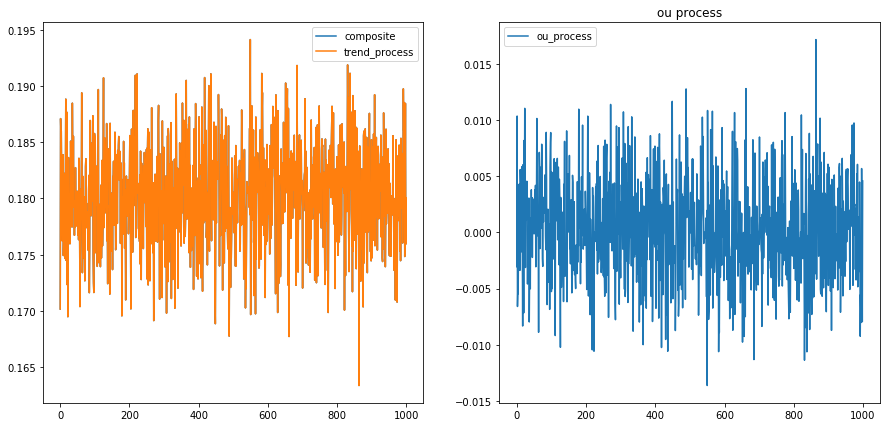

In [85]:
data = []
for i in range(1000):
    data.append(next(synth))
    
data = np.array(data)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(data[:, 0], label="composite")
# ax[0].plot(data[:, 1], label="ema")
ax[0].plot(data[:, 3], label="trend_process")
# ax[0].plot(data[:, 4], label="prev_y")
ax[1].plot(data[:, 2], label="ou_process")
# ax[1].plot(data[:, 5], label="ou_noise")
ax[0].legend()
ax[1].legend()
ax[1].set_title('ou process')